In [1]:
#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy
import numpy as np
import sys
from scipy import ndimage

import h5py
import time

from sscPimega import pi135D
from sscPimega import pi540D, opt540D
from sscPimega import misc
from sscIO import io

from PIL import Image
import cupy

import matplotlib as mpl
import matplotlib.colors as mcolors

from skimage.morphology import binary_dilation
from scipy.optimize import minimize 

from scipy import ndimage
from scipy import interpolate

from skimage.morphology import skeletonize, opening, closing, erosion, dilation, disk
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.morphology import convex_hull_image
from skimage.restoration import inpaint
from skimage import feature

from scipy.ndimage import gaussian_filter

In [130]:
n = 10
for i in range(135):
    if i % n == 0 and i > 0:
        print('aqui',i)
    

aqui 10
aqui 20
aqui 30
aqui 40
aqui 50
aqui 60
aqui 70
aqui 80
aqui 90
aqui 100
aqui 110
aqui 120
aqui 130


In [216]:
def geometry( L ):

    det = pi540D.get_detector_dictionary( L, {'geo':'nonplanar','opt':True,'mode':'virtual'}, )

    geo = pi540D.geometry540D( det )

    return geo, det

def projection_M_gpu_chapman( x, data ):
    
    sigma = cupy.std( data[ data > 0] )
    
    fft  = cupy.fft.fftn( x ) 
    fabs = cupy.abs(fft)
    eps  = 1e-5 
    
    mask1 = fabs > data + sigma
    mask2 = fabs < data - sigma
    
    fft[mask1] = (fft[mask1]/(fabs[mask1] + eps)) * (data[mask1] + sigma)
    fft[mask2] = (fft[mask2]/(fabs[mask2] + eps)) * (data[mask2] - sigma)
    
    result = cupy.fft.ifftn( fft )
    
    return result

def projection_M_gpu_old( x, data ):
    
    fft    = cupy.fft.fftn( x ) 
    phi    = cupy.angle( fft )
    result = data * cupy.exp(1j * phi)
        
    result[data<0] =  fft[data<0]
    
    result = cupy.fft.ifftn( result )
    
    return result
    
def projection_M_gpu( x, data ):
    
    fft    = cupy.fft.fftn( x ) 
    phi    = cupy.angle( fft )
    result = data * cupy.exp(1j * phi)
    diff =  cupy.abs(fft) - data 
    adiff = cupy.abs(diff)
    
    result[(data<0) | (adiff < 1)] =  fft[(data<0) | (adiff<1) ]
    
    tol = 1e-5 #jump@
    
    result[(data>=0) & (adiff >=1)] = fft[(data>=0) & (adiff>=1) ] * ( data[(data>=0) & (adiff>=1)] / ( numpy.maximum( numpy.abs(fft)[(data>=0) & (adiff>=1)] - diff[(data>=0) & (adiff>=1)]/ adiff[(data>=0) & (adiff>=1)], tol) ) )
    
    result = cupy.fft.ifftn( result )
    
    return result
    
    '''
    fft    = cupy.fft.fftn( x ) 
    phi    = cupy.angle(  fft  )
    result = data * cupy.exp(1j * phi)
    
    #result[(data<0)] =  fft[(data<0)]
        
    #result[(data>=0)] = fft[(data>=0) ] * ( data[(data>=0)] / ( numpy.maximum( numpy.abs(fft)[(data>=0)] - diff[(data>=0) & (adiff>=1)]/ adiff[(data>=0) & (adiff>=1)], tol) ) )
    
    result = cupy.fft.ifftn( result )
    
    #result = cupy.fft.ifftn(result)
    #result
    #result[ data < 0] = -1
    
    return result
    ''' 

def projection_S ( x, supp ):
    return x * supp

def projection_N ( x, supp ):
    #y = numpy.copy(x)
    #y.imag = 0
    #return y
    
    y    = numpy.copy(x.real)
    mask = (y < 0)
    y[ mask ] = 0
    return y

def hio_gpu( initial, measure, support, niterations, beta, method, dev, threshold):
    
    shrinkWrapSubIter = niterations[1]
    gniteration       = niterations[0]

    riterate = numpy.zeros([gniteration, initial.shape[0], initial.shape[1]])
    siterate = numpy.zeros([gniteration, initial.shape[0], initial.shape[1]])
    
    mempool = cupy.get_default_memory_pool()
    pinned_mempool = cupy.get_default_pinned_memory_pool()

    cupy.cuda.Device(dev).use()
        
    with cupy.cuda.Device(dev):
    
        dsupport = cupy.array(support)    
        smeasure = cupy.array( measure )
        x        = cupy.array( initial )
        csupport = cupy.array( 1-support )

        ES = numpy.zeros([gniteration,])
        EM = numpy.zeros([gniteration,])
        
        n     = support.shape[0]
        t     = numpy.linspace(-1,1,n)
        dt    = t[1] - t[0]
        xx,yy = numpy.meshgrid(t,t)
        xx_d  = cupy.array(xx)
        yy_d  = cupy.array(yy)
    
        G = lambda sigma: ( (1/(sigma*numpy.sqrt(2*numpy.pi))) * numpy.exp( -( (xx_d**2 + yy_d**2) / (2*sigma**2) ) ) )
        
        if method == "ER":
            idx = 0
            while ( idx < gniteration ):
                y = projection_M_gpu( x, smeasure )
                x = projection_S( y, dsupport )
                #x = projection_N( x, dsupport)
                idx += 1

        if method == "HIO":
            
            idx = 0
            sigma = 50 * dt

            while ( idx < gniteration ):
                
                
                #HIO
                '''
                xold = cupy.copy(x)
            
                y = projection_M_gpu( x, smeasure )
                vsupport = (y.real >= 0) * dsupport
                x = projection_S( y, vsupport ) + projection_S( x - beta * y,  1-vsupport )
                
                Psx = projection_S( x, vsupport)
                Pmx = projection_M_gpu(x, smeasure)
                ES[idx] = cupy.linalg.norm(x-Psx)/ cupy.linalg.norm(Psx)
                EM[idx] = cupy.linalg.norm(x-Pmx)/ cupy.linalg.norm(Pmx)

                if idx % shrinkWrapSubIter == 0 and idx > 0:
                    dsupport = cupy.abs(x) > (threshold/100.) * cupy.abs(x).max()
                    csupport = 1 - dsupport
                '''
                #G.Saxton
                y = projection_M_gpu( x, smeasure )
                vsupport = (y.real >= 0) * dsupport 
                x = projection_S( y, vsupport ) + projection_S( x - beta * y,  1-vsupport )

                Psx = projection_S( x, vsupport)
                Pmx = projection_M_gpu(x, smeasure)
                ES[idx] = cupy.linalg.norm(x-Psx)/ cupy.linalg.norm(Psx)
                EM[idx] = cupy.linalg.norm(x-Pmx)/ cupy.linalg.norm(Pmx)
                
                if idx % shrinkWrapSubIter == 0 and idx > 0 and sigma/dt > 3:
                    #--> z = conv (G, x - beta * y)
                    Gaussian = G(sigma)
                    Gaussian = cupy.array( Gaussian/Gaussian.max() )

                    z = cupy.fft.ifftn( cupy.fft.fftshift(Gaussian) * cupy.fft.fftn(x) )
                    
                    dsupport = cupy.abs( x ) > ( threshold/100. ) * cupy.abs( x ).max()
                    csupport = 1 - dsupport
                    
                    sigma = sigma / 2.0
                ##
                
                #print(idx, sigma)
                
                riterate[idx, :, :] = abs( x.get() )
                siterate[idx, :, :] = dsupport.get() 
                    
                idx += 1
                
                
        output = x.get()
    
    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()
        
    return output, dsupport.get(), [EM,ES], (riterate, siterate)
    
def get_roi(data, yc, xc, roi):
    return data[ max(0,yc - roi): min(yc + roi,3072) , max(0,xc - roi): min(xc + roi,3072)]

def flat_correction_gcc( img, flat, mask ):
    new = img * flat
    new[ mask < 0.5 ] = -1
    new[ new <=0 ] += 1
    return new

def flat_correction_det( img, flat ):
    new = img * flat
    new[ numpy.isnan(flat) ] = -1    
    return new

def set_border(img, p):
    col = img.shape[1]
    row = img.shape[0]
    new = numpy.copy(img)
    new[0:p, :] = -1
    new[row-p:row,:] = -1
    new[:,0:p] = -1
    new[:,col-p:col] = -1
    return new

In [3]:
def polar2cart(r, theta):
    return r*numpy.cos(theta), r*numpy.sin(theta)

def cart2polar(x, y):
    return numpy.arctan2(y,x), numpy.sqrt(x**2 + y**2)

def toPolar(cart, ac, ap, xc, yc, R, V):
    n       = cart.shape[0]
    dxy     = (2*ac)/float(n-1)
    m_angle = numpy.linspace(0,2*numpy.pi,V)
    m_ray   = numpy.linspace(0,ap,R)
    theta,R = numpy.meshgrid(m_angle, m_ray)
    X,Y     = polar2cart(R, theta)
    X       = X + xc
    Y       = Y + yc
    iX      = ((X+ac)/dxy).astype(int)
    iY      = ((Y+ac)/dxy).astype(int)

    iX[ iX >= n] = n-1
    iX[ iX < 0 ] = 0
    iY[ iY >= n] = n-1
    iY[ iY < 0]  = 0
    
    #nearest neighbourhood
    nearest = cart[iY,iX]
    polar   = nearest

    return polar


def rotate(im, angle, mesh):

    #mesh
    #N = img.shape[0]
    #x = numpy.linspace(-1,1,N)        
    #xx,yy=numpy.meshgrid(x,x)
    xx = mesh[0]
    yy = mesh[1]
    N  = mesh[2]
    x  = mesh[3]
    
    #mesh rotation
    X =   xx * numpy.cos(angle) + yy * numpy.sin(angle)
    Y = - xx * numpy.sin(angle) + yy * numpy.cos(angle)

    #index
    ix = numpy.floor((X - x[0])/(x[1]-x[0])).astype(numpy.int)
    iy = numpy.floor((Y - x[0])/(x[1]-x[0])).astype(numpy.int)

    ix[ ix > N-1] = N-1
    ix[ ix < 0] = 0
    iy[ iy > N-1] = N-1
    iy[ iy < 0] = 0

    return im[iy, ix]


def get_mask_center( rad, cx, cy, shape):
    
    t = numpy.linspace(-1,1,shape[0])
    dt = t[1] - t[0]
    x,y = numpy.meshgrid(t,t)
    mask = (x-t[cx])**2 + (y-t[cy])**2 < (rad * dt)**2
    return mask

    
def get_center(dbeam, project):

    aimg = opt540D._worker_annotation_image ( numpy.clip( dbeam, 0, 100) )
    aimg = ndimage.gaussian_filter( aimg, sigma=0.95, order=0 )
    aimg = aimg/aimg.max()
    aimg = 1.0 * ( aimg > 0.98 )    
    
    #plt.figure(figsize=(5,5))
    #plt.imshow(aimg)
    misc.imshow(aimg, (5,5))
    
    u = numpy.array(range(3072))
    xx,yy = numpy.meshgrid(u,u)
    
    xc = ((aimg * xx).sum() / aimg.sum() ).astype(int)
    yc = ((aimg * yy).sum() / aimg.sum() ).astype(int)
    #print(xc, yc)

    annotation = numpy.array([ [xc, yc] ])
    tracking = opt540D.annotation_points_standard ( annotation )
    tracking = opt540D.tracking540D_vec_standard ( project, tracking ) 
    
    xc = int( tracking[0][2] )
    yc = int( tracking[0][3] ) 
 
    #plt.figure(figsize=(20,20))
    #plt.imshow(aimg, vmin=0, vmax=0.5)


    '''
    s = 0
    xc_ = -1 + (xc + s) * 2.0/(3072-1)
    yc_ = -1 + yc * 2.0/(3072-1)
    
    pz = toPolar(back, 1, 1,xc_, yc_, 3072, 3072)
    '''
    return xc, yc


def get_center_datadomain(dbeam):

    aimg = pi540D._worker_annotation_image ( numpy.clip( dbeam, 0, 100) )
    aimg = ndimage.gaussian_filter( aimg, sigma=0.95, order=0 )
    aimg = aimg/aimg.max()
    aimg = 1.0 * ( aimg > 0.98 )
       
    plt.figure(figsize=(20,20))
    plt.imshow(aimg)
        
    u = numpy.array(range(3072))
    xx,yy = numpy.meshgrid(u,u)
    
    xc = ((aimg * xx).sum() / aimg.sum() ).astype(int)
    yc = ((aimg * yy).sum() / aimg.sum() ).astype(int)

    return xc, yc

def get_pixel_size( N, du, energy, z):
    
    energy_     = energy * 1000        # ev
    cvel        = 299792458            # m/s
    planck      = 4.135667662e-15      # ev * s
    wavelength  = cvel * planck/ (energy_)        
    
    # N * dx * du = dist * lambda
    
    return (z * wavelength) / ( (du * 1e-6)  * N )

def Restaurate(img, geom):
    return pi540D.backward540D(img, geom)

def restauration_processing_binning(img, args):
    flat, mask, geometry, cx, cy, hsize,  binning = args
    
    img = img * np.squeeze(flat) # Apply flatfield
    img = img.astype(np.float32) # convert to float
    img[np.abs(mask) == 1] = -1 # Apply Mask
    img = Restaurate(img, geometry) # restore
    img[img < 0] = -1 # all invalid values must be -1 by convention
    img = img[cy - hsize:cy + hsize, cx - hsize:cx + hsize]      # select ROI from the center (cx,cy)
    # Binning
    while binning % 2 == 0 and binning > 0:
        avg = img + np.roll(img, -1, -1) + np.roll(img, -1, -2) + np.roll(np.roll(img, -1, -1), -1, -2)  # sum 4 neigboors at the top-left value
        div = 1 * (img >= 0) + np.roll(1 * (img >= 0), -1, -1) + np.roll(1 * (img >= 0), -1, -2) + np.roll( np.roll(1 * (img >= 0), -1, -1), -1, -2)  # Boolean array! Results in the n of valid points in the 2x2 neighborhood
        avg = avg + 4 - div  # results in the sum of valid points only. +4 factor needs to be there to compensate for -1 values that exist when there is an invalid neighbor
        avgmask = (img < 0) & ( div > 0)  # div > 0 means at least 1 neighbor is valid. img < 0 means top-left values is invalid.
        img[avgmask] = avg[avgmask] / div[ avgmask]  # sum of valid points / number of valid points IF NON-NULL REGION and IF TOP-LEFT VALUE INVALID. What about when all 4 pixels are valid? No normalization in that case?
        img = img[:, 0::2] + img[:, 1::2]  # Binning columns
        img = img[0::2] + img[1::2]  # Binning lines
        img[img < 0] = -1
        img[div[0::2, 0::2] < 3] = -1  # why div < 3 ? Every neighborhood that had 1 or 2 invalid points is considered invalid?
        binning = binning // 2
    while binning % 3 == 0 and binning > 0:
        avg = np.roll(img, 1, -1) + np.roll(img, -1, -1) + np.roll(img, -1, -2) + np.roll(img, 1, -2) + np.roll( np.roll(img, 1, -2), 1, -1) + np.roll(np.roll(img, 1, -2), -1, -1) + np.roll(np.roll(img, -1, -2), 1, -1) + np.roll( np.roll(img, -1, -2), -1, -1)
        div = np.roll(img > 0, 1, -1) + np.roll(img > 0, -1, -1) + np.roll(img > 0, -1, -2) + np.roll(img > 0, 1, -2) + np.roll( np.roll(img > 0, 1, -2), 1, -1) + np.roll(np.roll(img > 0, 1, -2), -1, -1) + np.roll( np.roll(img > 0, -1, -2), 1, -1) + np.roll(np.roll(img > 0, -1, -2), -1, -1)
        avgmask = (img < 0) & (div > 0) / div[avgmask]
        img = img[:, 0::3] + img[:, 1::3] + img[:, 2::3]
        img = img[0::3] + img[1::3] + img[2::3]
        img[img < 0] = -1
        binning = binning // 3
    if binning > 1:
        print('Entering binning > 1 only')
        avg = -img * 1.0 + binning ** 2 - 1
        div = img * 0
        for j in range(0, binning):
            for i in range(0, binning):
                avg += np.roll(np.roll(img, j, -2), i, -1)
                div += np.roll(np.roll(img > 0, j, -2), i, -1)
        avgmask = (img < 0) & (div > 0)
        img[avgmask] = avg[avgmask] / div[avgmask]
        imgold = img + 0
        img = img[0::binning, 0::binning] * 0
        for j in range(0, binning):
            for i in range(0, binning):
                img += imgold[j::binning, i::binning]
        img[img < 0] = -1
    return img

In [4]:
get_pixel_size( 1024, 55, 8.2, 27) * 1e+9

72.48591085408405

# CATERETE / DATA Analysis


### Load data

In [193]:
if False:
    energy = 6
    distance = 28000
    nproc    = 140

    #zeolite
    path ='/ibira/lnls/beamlines/caterete/proposals/20221263/data/'

    path_data  = path + 'glass2_20umpinhole_008.hdf5'
    path_empty = '/ibira/lnls/beamlines/caterete/proposals/20210072/data/pwCDI/pwCDI_zeo02/images/empty.hdf5'
    path_bkg   = path + 'glass2_20umpinhole_bkg_009.hdf5'
    path_flat  = '/ibira/lnls/beamlines/caterete/proposals/20210072/data/pwCDI/pwCDI_zeo02/images/flat.tif'
    path_dbeam = path + 'dbeam_220901_004.hdf5'

    count,_ = io.read_volume(path_data, 'numpy', use_MPI=True, nprocs=32)
    back,_ = io.read_volume(path_bkg, 'numpy', use_MPI=True, nprocs=32)

    empty = h5py.File(path_empty,'r')['entry/data/data/'][0,0,:,:]
    dbeam = h5py.File(path_dbeam,'r')['entry/data/data/'][0,0,:,:]
    flat  = numpy.array( Image.open(path_flat) )

    It = numpy.zeros([2,2])
    It[0,1] = 0.04401166666666667
    It[1,1] = 0.05970833333333333
        
    print(count.shape)
    print(back.shape)

    for k in range( count.shape[0]):
        count[k,:,:][empty > 0] = -1
        back[k,:,:][empty > 0] = -1
    

if True:
    energy = 6
    distance = 20000
    nproc    = 140

    #zeolite
    path ='/ibira/lnls/beamlines/caterete/proposals/20210072/data/pwCDI/pwCDI_zeo02/'

    path_data  = path + '/scans/pwCDI_zeo02_0000.hdf5'
    path_empty = path + '/images/empty.hdf5'
    path_flat  = path + '/images/flat.tif'
    path_dbeam = path + '/images/dbeam.hdf5'
    path_mask  = path + '/images/mask.npy'
    path_trans = path + '/devices/pwCDI_zeo02_IT.txt' 
    path_angles = path + '/devices/pwCDI_zeo02_Ry_positions.txt' 

    data,_ = io.read_volume(path_data, 'numpy', use_MPI=True, nprocs=32)

    count = data[0:data.shape[0]:2,:,:]
    back  = data[1:data.shape[0]:2,:,:]
    empty = h5py.File(path_empty,'r')['entry/data/data/'][0,0,:,:]
    dbeam = h5py.File(path_dbeam,'r')['entry/data/data/'][0,0,:,:]
    bmask = numpy.load(path_mask).astype(numpy.float32)
    flat  = numpy.array( Image.open(path_flat) )

    It = numpy.loadtxt(path_trans,skiprows=1)
    angles = numpy.loadtxt(path_angles)

    print(count.shape)
    print(back.shape)
    
    for k in range(count.shape[0]):
        count[k,:,:][empty > 0] = -1
        back[k,:,:][empty > 0] = -1
    
    
if False:
    energy = 6
    distance = 20000
    nproc    = 140

    #sphere
    path = '/ibira/lnls/beamlines/caterete/proposals/20210072/data/pwCDI/pwCDI_glass01'

    path_data  = path + '/scans/pwCDI_glass01_0000.hdf5'
    path_empty = path + '/images/empty.hdf5'
    path_flat  = path + '/images/flat.tif'
    path_dbeam = path + '/images/dbeam.hdf5'
    path_mask  = path + '/images/mask.npy'
    path_trans = path + '/devices/pwCDI_glass01_IT.txt' 
    path_angles = path + '/devices/pwCDI_glass01_Ry_positions.txt' 

    data,_ = io.read_volume(path_data, 'numpy', use_MPI=True, nprocs=32)

    count = data[0:data.shape[0]:2,:,:]
    back  = data[1:data.shape[0]:2,:,:]
    empty = h5py.File(path_empty,'r')['entry/data/data/'][0,0,:,:]
    dbeam = h5py.File(path_dbeam,'r')['entry/data/data/'][0,0,:,:]
    bmask = numpy.load(path_mask).astype(numpy.float32)
    flat  = numpy.array( Image.open(path_flat) )

    It = numpy.loadtxt(path_trans,skiprows=1)
    angles = numpy.loadtxt(path_angles)

    print(count.shape)
    print(back.shape)
    
    for k in range(count.shape[0]):
        count[k,:,:][empty > 0] = -1
        back[k,:,:][empty > 0] = -1
    

-- Calling MPI code to read /ibira/lnls/beamlines/caterete/proposals/20210072/data/pwCDI/pwCDI_zeo02//scans/pwCDI_zeo02_0000.hdf5
(700, 3072, 3072)
(700, 3072, 3072)


1208 1433
1211 1441
1215 1444


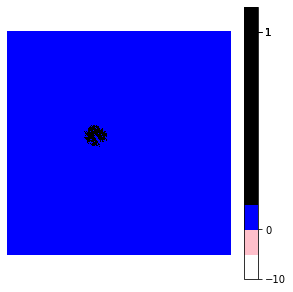

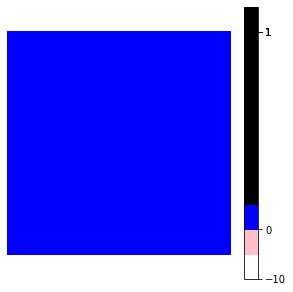

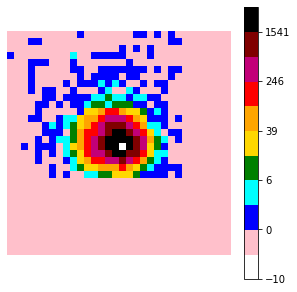

In [194]:
roiSize  = 512
binning  = 1
susp     = 5
geo, project = geometry(distance)
geo['geom']['susp'] = [susp, susp]

##

cx, cy = get_center(count[0,:,:], project)
print(cx, cy)

roiS = 16
DB = dbeam[cy-roiS:cy+roiS, cx-roiS:cx+roiS]

tmp = numpy.zeros(dbeam.shape) 
tmp[cy-roiS:cy+roiS, cx-roiS:cx+roiS] = dbeam[cy-roiS:cy+roiS, cx-roiS:cx+roiS]

cx, cy = get_center(tmp, project)
print(cx, cy)

#cx = cx + 8
#cy = cy - 2

cx += 4
cy += 3

print(cx, cy)

tmp[cy,cx] = -1

misc.imshow(tmp[cy-roiS:cy+roiS, cx-roiS:cx+roiS], (5,5))

#bmask  = numpy.zeros(flat.shape)

params = (flat, bmask, geo, cx, cy, roiSize, binning)

array([-1.00000000e+01, -1.00000000e-01,  0.00000000e+00,  8.66200598e+00,
        7.50303476e+01,  6.49913320e+02,  5.62955306e+03,  4.87632223e+04,
        4.22387323e+05,  3.65872152e+06,  3.16918677e+07,  2.74515148e+08])

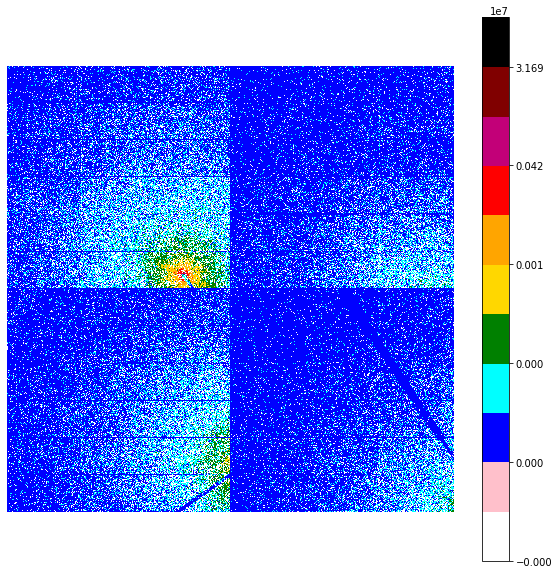

In [195]:
misc.imshow( count[0,:,:]/It[0,1] -  back[0,:,:]/ It[1,1] , (10,10) )

sscPimega: creating 700x1024x1024 shared array (SharedArray)
Done: 700 Images corrected within 14.25380539894104 sec
    :    Shared Array creation 0.00043582916259765625 sec
(700, 1024, 1024)


array([-1.00000000e+01, -1.00000000e-01,  0.00000000e+00,  8.55450544e+00,
        7.31795633e+01,  6.26014972e+02,  5.35524848e+03,  4.58115023e+04,
        3.91894745e+05,  3.35246573e+06,  2.86786863e+07,  2.45331904e+08])

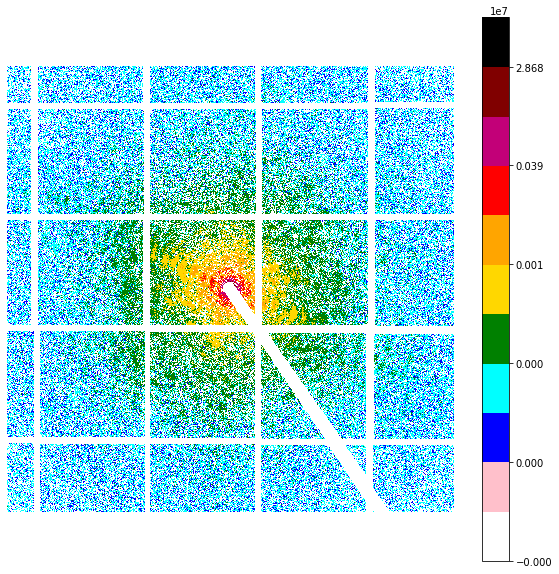

In [196]:
oshape = [2*roiSize//binning, 2*roiSize//binning]

normalized = count[:,:,:]/It[0,1] -  back[:,:,:]/ It[1,1]

output, _ = pi540D.backward540D_nonplanar_batch( normalized , distance, nproc, oshape, restauration_processing_binning, params, 'only' )

print(output.shape)

misc.imshow(output[0,:,: ], (10,10) )

In [ ]:
#import gc
#del count, back
#gc.collect()

In [197]:
def removeBorders(img, n):
    r,c = img.shape
    img[0:n,:] = 0
    img[r-n:r,:] = 0
    img[:,0:n] = 0
    img[:,c-n:c] = 0
    return img

def _operator_T(u):
    pad = 10
    u = numpy.pad(u, (pad,pad))
    
    p   =  1 #positive
    n   = -1 #negative
    uxx = (np.roll(u,p,1) - 2 * u + np.roll(u,n,1) ) 
    uyy = (np.roll(u,p,0) - 2 * u + np.roll(u,n,0) ) 

    trace = uxx + uyy

    uyx = ( np.roll(u,p,1) - np.roll(u,n,0) - np.roll(u,n,0) + np.roll(u,n,1) )/ (2*numpy.sqrt(2))
    #uxy = ( np.roll(u,p,0) - np.roll(u,n,1) - np.roll(u,p,1) + np.roll(u,n,0) )/ (2*numpy.sqrt(2))
       
    uxy = (np.roll(np.roll(u,p,1),p,0) - np.roll(np.roll(u,n,1),p,0) - np.roll(np.roll(u,p,1),n,0) + np.roll(np.roll(u,n,1),n,0))/4.0
    
    #back-back
    #uyx = np.roll(np.roll(u,p,1),p,0) - np.roll(u,p,0) - np.roll(u,p,1) + u
    #forw-forw
    #uxy = u - np.roll(u,n,0) - np.roll(u,n,1) + np.roll(np.roll(u,n,0),n,1)
    
    delta = (uxx + uyy)**2 - 4 * (uxx * uyy - uyx * uxy)

    delta = removeBorders(delta, pad*2)
    uyx   = removeBorders(uyx, pad*2)
    uxy   = removeBorders(uxy, pad*2)
    trace = removeBorders(trace, pad*2)
    
    delta = delta[pad:delta.shape[0]-pad,pad:delta.shape[1]-pad]
    uyx   = uyx[pad:uyx.shape[0]-pad,pad:uyx.shape[1]-pad]
    uxy   = uxy[pad:uxy.shape[0]-pad,pad:uxy.shape[1]-pad]
    trace = trace[pad:trace.shape[0]-pad,pad:trace.shape[1]-pad]
    
    T = numpy.sqrt(delta + 0*1j)
    
    return delta #T.imag #delta, trace, abs(uyx - uxy)

### 2D

array([-1.00000000e+01, -1.00000000e-01,  0.00000000e+00,  8.55450544e+00,
        7.31795633e+01,  6.26014972e+02,  5.35524848e+03,  4.58115023e+04,
        3.91894745e+05,  3.35246573e+06,  2.86786863e+07,  2.45331904e+08])

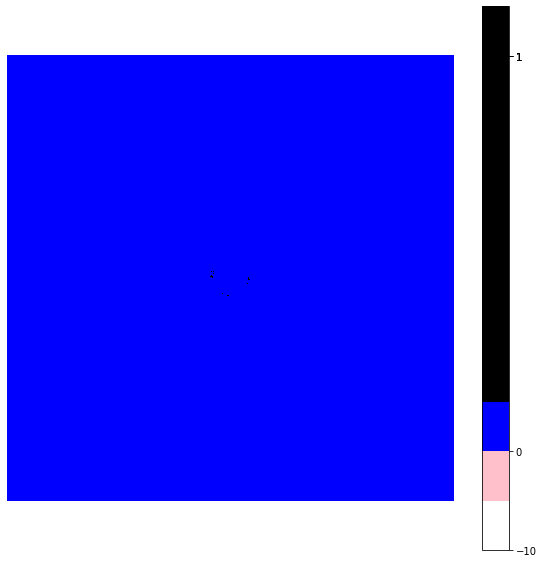

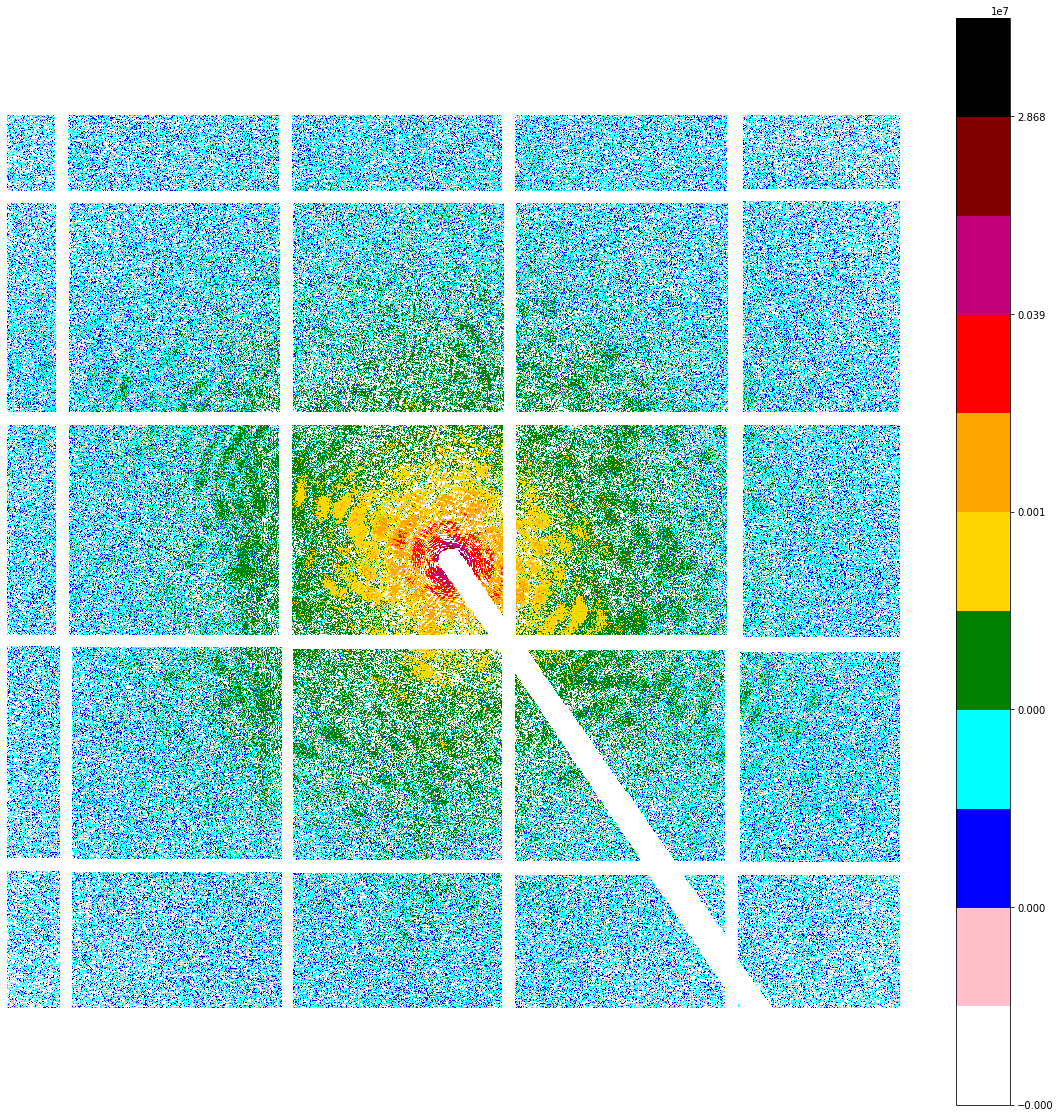

In [198]:
T = _operator_T( output[0,:,:] )
#misc.imshow( output[0,:,:] , (10,10))

dil = dilation( T > (20/100.)*T.mean() )

cmask = get_mask_center( 40, dil.shape[0]//2, dil.shape[1]//2, dil.shape)

dil[cmask > 0] = 0

misc.imshow( dil , (10,10))
misc.imshow( output[0,:,:], (20,20))

array([-1.00000000e+01, -1.00000000e-01,  0.00000000e+00,  8.55450544e+00,
        7.31795633e+01,  6.26014972e+02,  5.35524848e+03,  4.58115023e+04,
        3.91894745e+05,  3.35246573e+06,  2.86786863e+07,  2.45331904e+08])

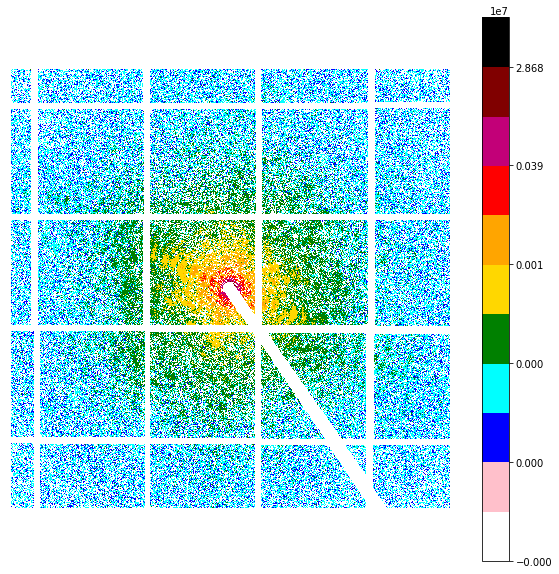

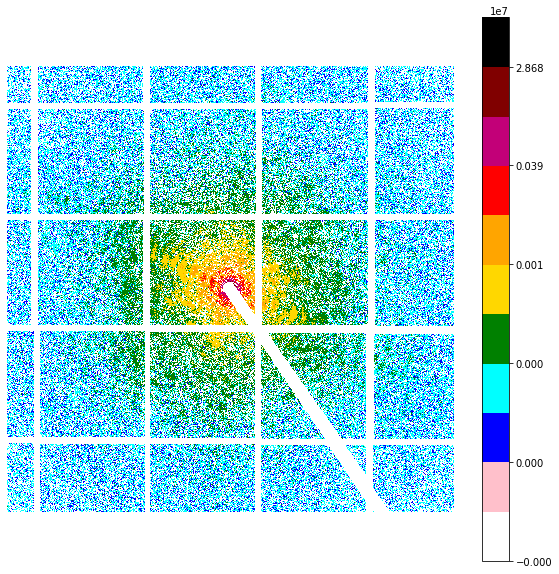

In [222]:
def symmetry( roi ):

    N  = roi.shape[0]
    yc = N//2
    xc = N//2
    
    TL = roi[0:yc,0:xc]
    TR = roi[0:yc,xc:N]
    BL = roi[yc:N,0:xc]
    BR = roi[yc:N,xc:N]
    
    mBL = (BL < 0)
    mBR = (BR < 0)
    
    #BR = numpy.flipud( numpy.fliplr(TL))
    #BL = numpy.fliplr( numpy.flipud(TR))
     
    BR[ mBR ] = numpy.flipud( numpy.fliplr(TL))[mBR]
    BL[ mBL ] = numpy.fliplr( numpy.flipud(TR))[mBL]
            
    top = numpy.hstack((TL,TR))
    bottom = numpy.hstack((BL,BR))
    changeBelow = numpy.vstack((top,bottom))
    
    newBelow = numpy.maximum( roi, changeBelow )
    
    #
    
    TL = roi[0:yc,0:xc]
    TR = roi[0:yc,xc:N]
    BL = roi[yc:N,0:xc]
    BR = roi[yc:N,xc:N]
    
    mTL = (TL < 0)
    mTR = (TR < 0)
    
    #TR = numpy.flipud( numpy.fliplr(BL))
    #TL = numpy.fliplr( numpy.flipud(BR))
    
    TR[ mTR ] = numpy.flipud( numpy.fliplr(BL))[mTR]
    TL[ mTL ] = numpy.fliplr( numpy.flipud(BR))[mTL]
    
    
    top = numpy.hstack((TL,TR))
    bottom = numpy.hstack((BL,BR))
    changeAbove = numpy.vstack((top,bottom)) 
    
    newAbove = numpy.maximum( roi, changeAbove )
    
    return numpy.maximum(newAbove, newBelow), (newAbove, newBelow)

boundary = 10

roi = numpy.copy(output[0,:,:])

T = _operator_T(roi)

where = dilation( T > (20/100.)*T.mean() )

cmask = get_mask_center( 40, where.shape[0]//2, where.shape[1]//2, where.shape)

where[cmask > 0] = 0

roi [ where > 0 ] = -1

if True:
    ## smoothing
    swhere = (roi < 0)
    roi = gaussian_filter( roi, sigma=0.0 )
    roi[swhere] = -1
if False:
    ## forcing symmetry
    roi, tmp = symmetry(roi)

roi = set_border(roi, boundary)

roi = get_roi(roi, roi.shape[0]//2, roi.shape[1]//2, 512)

misc.imshow(roi, (10,10))
misc.imshow(output[0,:,:], (10,10))

In [12]:
output.shape

(1400, 1024, 1024)

(745, 745)


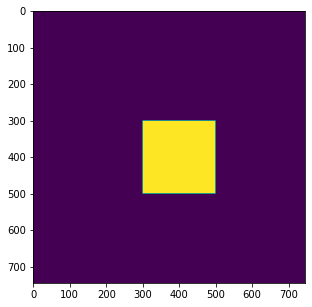

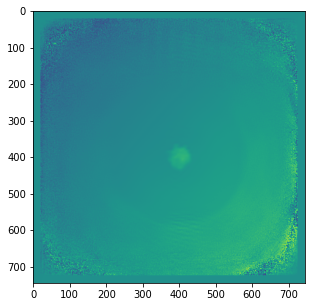

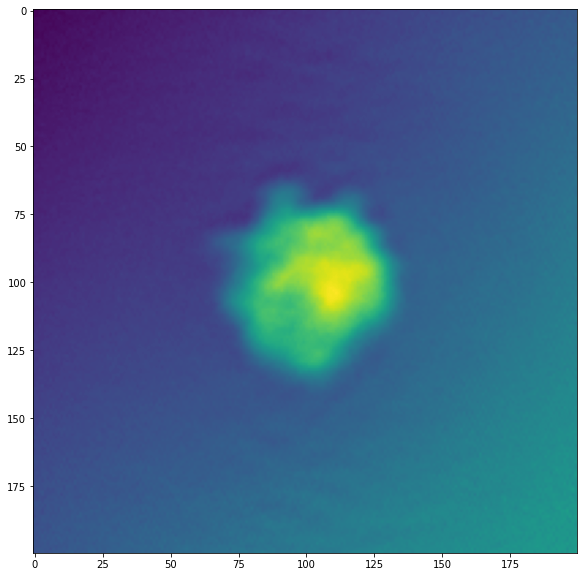

In [200]:
'''
   #Ptycho
   "object_pixel": 3.65984692235962e-08
   "wavelength": 2.0664032897701555e-10
   "energy": 6
   "DetDistance": 19.94988874511719,
'''

#'''
_pmask_ = numpy.load('esferaMask.npy')

_ptycho_ = numpy.load('esferaPtycho.npy')

plt.figure(figsize=(5,5))
plt.imshow(_pmask_)

plt.figure(figsize=(5,5))
plt.imshow(_ptycho_)

#onde =  (_pmask_ > 0)
#
#_ptychoz_ = _ptycho_[onde]
#
plt.figure(figsize=(10,10))
plt.imshow(_ptycho_[300:500,300:500])


print(_ptycho_.shape)
#'''

pxlsize@recon (nm):  73.38079864240609


'\nplt.figure(figsize=(10,10))\nplt.imshow(  _ptycho_ )\n\nplt.figure(figsize=(10,10))\nplt.imshow( abs( recon_hio ) )\n\n#plt.figure(figsize=(10,10))\ntmp = abs( numpy.fft.fftshift( numpy.fft.fftn( numpy.pad( _ptycho_, (512,512) )  ) )  )**2\ns = 3\ntmp[tmp.shape[0]//2 -s:tmp.shape[0]//2 + s, tmp.shape[0]//2 - s:tmp.shape[0]//2 + s] = -1\nmisc.imshow( tmp , (10,10))\n\nmisc.imshow( roi[ roi.shape[0]//2 - 100:roi.shape[0]//2 + 100, roi.shape[0]//2 - 100:roi.shape[0]//2 + 100 ], (10,10))\n\nmisc.imshow( back[0,:,:][0:1536,0:1536][1300:-1,900:-1][:,200:-200], (10,10))\n'

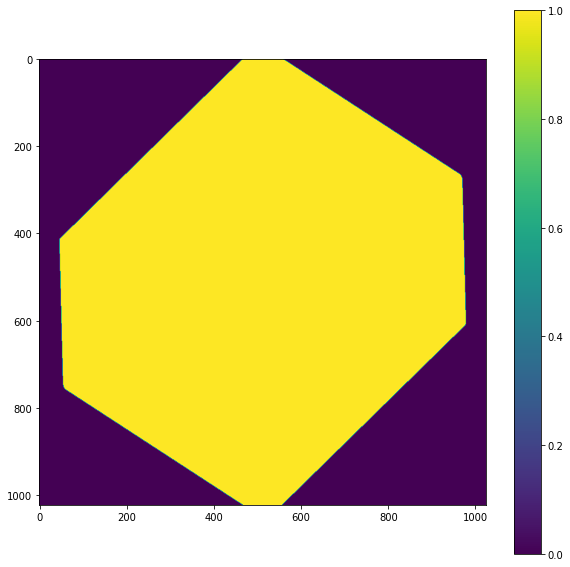

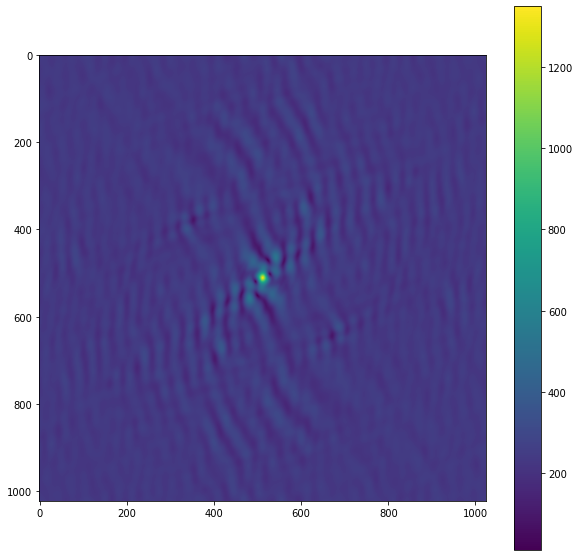

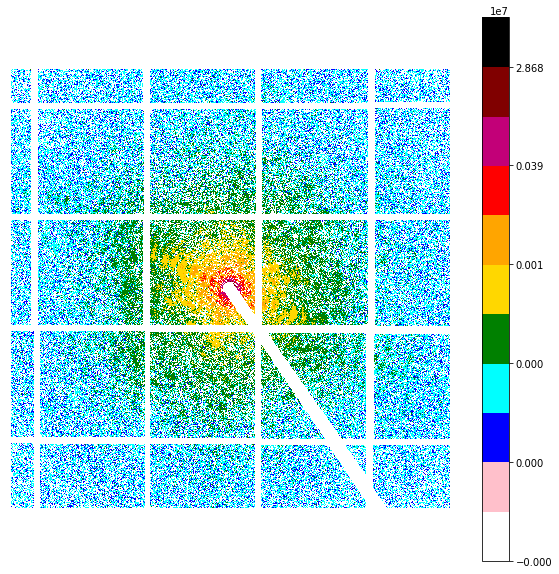

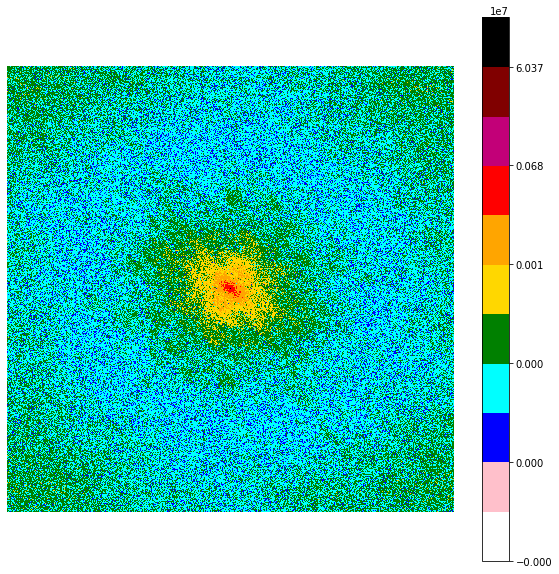

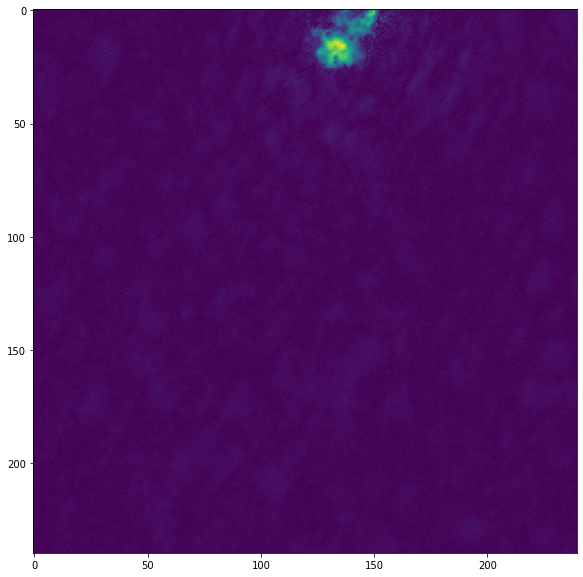

In [232]:
_energy_ = energy

t = numpy.linspace(-1,1,roi.shape[0])
xx,yy = numpy.meshgrid(t,t)

dx = 2.0/roi.shape[0]
s = 60
p = 10
th= 0*numpy.pi/180.  #-60 * numpy.pi/180.

a = 1 #1.8
b = 1 #3.8
support = 1.0*( ((a*(xx*numpy.cos(th)-yy*numpy.sin(th))**p + b*(xx*numpy.sin(th)+yy*numpy.cos(th))**p)**(1.0/p) < (dx*s)) )
#support = 1.0 * ( (numpy.maximum(abs(xx*numpy.cos(th)-yy*numpy.sin(th)), abs(xx*numpy.sin(th)+yy*numpy.cos(th)) ) < dx*s) ) 

#support = zoom_feature(chull,15) 

#support = numpy.abs(recon_hio) > numpy.abs(recon_hio).mean()  

print('pxlsize@recon (nm): ', get_pixel_size( roi.shape[0], 55, _energy_, distance/1000.) * 1e+9 )

beta = 0.9

measure = numpy.fft.fftshift(roi)
measure[ measure > 0] = numpy.sqrt(measure[measure>0])

#D = (measure.shape[0] - _pmask_.shape[0])//2
#support = numpy.pad( _pmask_ , (D,D) )

if True:
    measure2 = measure**2
    measure2[ measure < 0] = -1
    autocorr = abs( numpy.fft.fftshift( numpy.fft.ifft2( measure2 ) ) )
    support = convex_hull_image ( opening( (autocorr > (20/100.0) * autocorr.max()) ) )

plt.figure(figsize=(10,10))
plt.imshow(support)
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(autocorr)
plt.colorbar()



initial = numpy.fft.fftshift( numpy.fft.ifft2( measure * numpy.exp(-1j * numpy.random.rand(roi.shape[0],roi.shape[1]) ) ).real )
#initial = support

threshold = 10 #%

recon_hio, supp, error = hio_gpu( initial, measure, support, [600, 100], beta, "HIO", 5, threshold) 

#recon_er,_,_      = hio_gpu( recon_hio, measure, supp, [100, 5], beta, "ER", 5, threshold ) 

#recon_hio *= support
#recon_er  *= support

    
'''
means=False
if means:
    n = 10
    recon_er_ = numpy.zeros([n, recon_er.shape[0],recon_er.shape[1]])
    recon_er_[0,:,:] = recon_er
    for k in range(1,n):
        initial = numpy.fft.ifft2( measure * numpy.exp(1j * numpy.random.rand(roi.shape[0],roi.shape[1]) ) ).real
        recon_hio_tmp = hio_gpu( initial, measure, support, niteration, beta, "HIO", 5 )
        recon_er_[k,:,:] = hio_gpu( recon_hio_tmp, measure, support, niteration, beta, "ER", 5 )
        print(k)

    recon_er = recon_er_.mean(0)

recon_er = support * numpy.abs( recon_er )
recon_hio = support * numpy.abs( recon_hio )

recon_er_zoom = get_roi ( numpy.abs(recon_er), recon_er.shape[0]//2, recon_er.shape[1]//2, 2*s)
recon_hio_zoom = get_roi ( numpy.abs(recon_hio), recon_er.shape[0]//2, recon_er.shape[1]//2, 2*s)
'''

#print(med)
#misc.imshow( med * med.shape[0]*med.shape[1]), (10,10))

medida = numpy.abs( numpy.fft.fftshift(numpy.fft.fftn(abs(recon_hio))) )**2

misc.imshow( roi, (10, 10))

misc.imshow(medida, (10,10))

plt.figure(figsize=(10,10))
s = 2*s
plt.imshow( abs( recon_hio)[ measure.shape[0]//2-s:measure.shape[0]//2+s, measure.shape[0]//2-s:measure.shape[0]//2+s])

#plt.figure(figsize=(10,10))
#plt.imshow( abs( recon_er)[measure.shape[0]//2-s:measure.shape[0]//2+s, measure.shape[0]//2-s:measure.shape[0]//2+s] )  


'''
plt.figure(figsize=(10,10))
plt.imshow(  _ptycho_ )

plt.figure(figsize=(10,10))
plt.imshow( abs( recon_hio ) )

#plt.figure(figsize=(10,10))
tmp = abs( numpy.fft.fftshift( numpy.fft.fftn( numpy.pad( _ptycho_, (512,512) )  ) )  )**2
s = 3
tmp[tmp.shape[0]//2 -s:tmp.shape[0]//2 + s, tmp.shape[0]//2 - s:tmp.shape[0]//2 + s] = -1
misc.imshow( tmp , (10,10))

misc.imshow( roi[ roi.shape[0]//2 - 100:roi.shape[0]//2 + 100, roi.shape[0]//2 - 100:roi.shape[0]//2 + 100 ], (10,10))

misc.imshow( back[0,:,:][0:1536,0:1536][1300:-1,900:-1][:,200:-200], (10,10))
'''

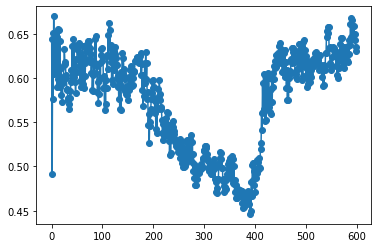

In [228]:
plt.plot(error[0][:],'o-')

In [ ]:
# teste autocorrelacao
'''
t = numpy.linspace(-1,1,512)
x, y = numpy.meshgrid( t, t)
img = (abs(x) + abs(y) < 0.1)*1.0

sy = -10
sx = 4
data = numpy.roll( numpy.roll( abs(numpy.fft.fft2(img))**2, sy, 0), sy, 1)

autocorr = numpy.fft.fftshift( numpy.fft.ifft2( data ).real )


support = autocorr > (2/100.) * autocorr.max()

plt.figure(figsize=(5,5))
plt.imshow(support)

plt.figure(figsize=(5,5))
plt.imshow(img)
'''

In [ ]:
plt.plot( angles , '-o')

In [ ]:
def get_diffractogram3d( diff2d, angles, roiSize):
            
    nangles = diff2d.shape[0]
    imgsize = 2*roiSize
    
    x0    = -1
    xf    =  1
    t     = numpy.linspace(x0,xf,imgsize,endpoint=False)
    dxyz  = t[1] - t[0]
    xx,yy = numpy.meshgrid(t,t)
    c     = 0
    
    nangles = len(angles)
    
    output = numpy.zeros([imgsize,imgsize,imgsize],dtype=numpy.float32)
    count  = numpy.zeros([imgsize,imgsize,imgsize],dtype=numpy.float32)

    x_,y_,z_ = numpy.meshgrid(t,t,t)
    outside = ((x_)**2 + (y_)**2 + (z_)**2> 1 )  
    
    for k in range(nangles):
                
        #rotation
        RY = numpy.array([[numpy.cos(angles[k]), 0, numpy.sin(angles[k])],[0,1,0],[-numpy.sin(angles[k]),0,numpy.cos(angles[k])]])

        xr = RY[0,0] * (xx-c) + RY[0,1] * (yy-c) + RY[0,2] * (-0)
        yr = RY[1,0] * (xx-c) + RY[1,1] * (yy-c) + RY[1,2] * (-0)
        zr = RY[2,0] * (xx-c) + RY[2,1] * (yy-c) + RY[2,2] * (-0)

        ix = ( numpy.floor( (xr - x0)/dxyz )).astype(numpy.int) 
        iy = ( numpy.floor( (yr - x0)/dxyz )).astype(numpy.int)
        iz = ( numpy.floor( (zr - x0)/dxyz )).astype(numpy.int)

        ix[ ix < 0] = 0
        ix[ ix > 2*roiSize - 1] = 2*roiSize - 1
        iy[ iy < 0] = 0
        iy[ iy > 2*roiSize - 1] = 2*roiSize - 1
        iz[ iz < 0] = 0
        iz[ iz > 2*roiSize - 1] = 2*roiSize - 1    

        boundary = 10

        roi = diff2d[k,:,:]

        T = _operator_T( roi  )

        where = dilation( T > (20/100.)*T.mean() )

        cmask = get_mask_center( 40, where.shape[0]//2, where.shape[1]//2, where.shape)

        where[cmask > 0] = 0

        roi [ where > 0 ] = -1

        if True:
            ## smoothing
            swhere = (roi < 0)
            roi = gaussian_filter( roi, sigma=0.8 )
            roi[swhere] = -1
        if False:
            ## forcing symmetry
            roi, tmp = symmetry(roi)

        roi = set_border(roi, boundary)
        
        count[ix,iy,iz] += 1
        output[ix, iy, iz] =  roi

        print(k)
        
    mask = (output == -1)
    output[ count > 0 ] = output[count >0 ] / count[ count > 0 ]
    output[outside] = -1
    output[mask] = -1
        
    return output

In [ ]:
diff3d = get_diffractogram3d( output, angles * numpy.pi/180., roiSize )

In [ ]:
numpy.save('diff3dSphere.npy',diff3d)

# 3D

In [ ]:
diff3d = numpy.load('diff3dSphere.npy')#[::2,::2,::2]

In [ ]:
start = time.time()

numpy.fft.ifftn(diff3d)

elapsed = time.time() - start

print('Elapsed (1FFT):', elapsed)

In [ ]:
print(diff3d.shape)

diff3d[ diff3d == 0] = -1

misc.imshow( numpy.fft.fftshift( diff3d) [:,0], (10,10))

In [ ]:
t = numpy.linspace(-1,1,diff3d.shape[0])
xx,yy,zz = numpy.meshgrid(t,t,t)
dxyz = t[1] - t[0]
s = 28
p = 10
support = 1.0*( (((xx)**p + (yy)**p + (zz)**p ) < (dxyz*s)**p) ) #  & ( ( abs(xx) + abs(yy) + abs(zz) < dx*s ) ) )

beta = 0.9

measure = numpy.fft.fftshift(diff3d)
measure[ measure > 0] = numpy.sqrt( measure[measure>0] )

#autocorr = abs( numpy.fft.fftshift( numpy.fft.ifft2( measure**2 ) ) )
#support = convex_hull_image ( opening( (autocorr > (20/100.0) * autocorr.max()) ) )

#plt.figure(figsize=(10,10))
#plt.imshow(support)
#plt.colorbar()

initial = numpy.fft.fftshift( numpy.fft.ifftn( measure * numpy.exp(-1j * numpy.random.rand(diff3d.shape[0],diff3d.shape[1],diff3d.shape[2]) ) ).real )
#initial = support

threshold = 10 #%

recon_hio, supp, med = hio_gpu( initial, measure, support, [100, 100, 10], beta, "HIO", 5, threshold) 
#recon_er,_,_      = hio_gpu( recon_hio, measure, supp, [100, 80, 10], beta, "ER", 5, threshold ) 

#plt.figure(figsize=(10,10))
#plt.imshow( abs( recon_hio) [ measure.shape[0]//2-s:measure.shape[0]//2+s, measure.shape[0]//2-s:measure.shape[0]//2+s])

#plt.figure(figsize=(10,10))
#plt.imshow( abs( recon_er)[ measure.shape[0]//2-s:measure.shape[0]//2+s, measure.shape[0]//2-s:measure.shape[0]//2+s] )  

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow( abs(recon_hio)[:,128,:] )